In [16]:
import os
import numpy as np
from matplotlib import pyplot as plt
import cv2
try:
    from PIL import Image
except ImportError:
    import Image
import pytesseract

np.seterr(divide='ignore', invalid='ignore')

# Tesseract-OCR executable
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

# Image samples
SAMPLE_1 = 'sample01.png'
SAMPLE_1_GROUND_TRUTH = os.path.join('out', 'correct_1.txt')
SAMPLE_2 = 'sample02.png'
SAMPLE_2_GROUND_TRUTH = os.path.join('out', 'correct_2.txt')

## Utils

In [2]:
def indent(string, num_spaces, addTripleQuotes=True):
    if addTripleQuotes:
        string = "'''\n" + string + "\n'''\n"
    return '\n'.join([((' ' * num_spaces) + line) for line in string.split("\n")])

def within_intensity_rng(min_, max_):
    if (min_ != 0 and max != 255):
        return True
    return False

def imshow(img, title, figsize=(16,16)):
    plt.figure(figsize=figsize)
    plt.imshow(img, cmap = 'gray')
    plt.title(title);

## Metrics

In [3]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def get_cosine_sim(query, document): 
    text = [query, document]
    count_vec = CountVectorizer()
    count_vec.fit(text)
    arr = count_vec.transform(text).toarray()
    vector1, vector2 = arr
    return cosine_similarity(np.array([vector1]), np.array([vector2]))[0][0]

def get_jaccard_sim(query, document):
    query = query.split()
    document = document.split()
    intersection = set(query).intersection(set(document))
    union = set(query).union(set(document))
    if len(union) == 0:
        print('No similar words')
        return 0
    return len(intersection)/len(union)

def get_levenshtein_sim(query, document):
    size_x = len(query) + 1
    size_y = len(document) + 1
    matrix = np.zeros((size_x, size_y), dtype=int)
    for x in range(size_x):
        matrix [x, 0] = x
    for y in range(size_y):
        matrix [0, y] = y

    for x in range(1, size_x):
        for y in range(1, size_y):
            if query[x-1] == document[y-1]:
                matrix [x,y] = min(
                    matrix[x-1, y] + 1,
                    matrix[x-1, y-1],
                    matrix[x, y-1] + 1
                )
            else:
                matrix [x,y] = min(
                    matrix[x-1, y] + 1,
                    matrix[x-1, y-1] + 1,
                    matrix[x, y-1] + 1
                )
#     print (matrix)
    distance =  matrix[size_x - 1, size_y - 1]
    return (size_x + size_y - distance) / (size_x + size_y)

In [4]:
def get_metric_score(img, ground_truth_pth):
    img_str = pytesseract.image_to_string(img).strip()
    print(f"{'=' * 18} Results {'=' * 18}")
    print(f"\n{indent(img_str, 3)}")
    with open(ground_truth_pth, 'r') as f:
        ground_truth = f.read().strip()
        
        jaccard_sim = get_jaccard_sim(img_str, ground_truth)
        cosine_sim = get_cosine_sim(img_str, ground_truth)
        levenshtein_sim = get_levenshtein_sim(img_str, ground_truth)
        
        print(f"-> Jaccard Similarity:    \t{jaccard_sim}")
        print(f"-> Cosine Similarity:     \t{cosine_sim}")
        print(f"-> Levenshtein Similarity:\t{levenshtein_sim}")
        
        avg_score = (jaccard_sim + cosine_sim + levenshtein_sim) / 3
        print(f"\n-> Average Score: {avg_score:.5f}")
        
    return avg_score, [jaccard_sim, cosine_sim, levenshtein_sim]

## Algorithms

In [5]:
def contrast_stretching(img):
    img = np.array(img)
    min_ = img.min()
    max_ = img.max()
    print(min_, max_)
    
    assert within_intensity_rng(min_, max_)
    
    img = np.subtract(img, min_)
    img = np.multiply(img, 255 / (max_ - min_))

    return img.astype(np.uint8)

def thresholding(img, low):
    assert low < 256 and low > -1
#     img = img.convert('L')
    img = np.array(img)
    thres = np.zeros(img.shape).astype(np.uint8)
    thres[np.where(img > low)] = 1
    return thres

def otsu_thresholding(img):
#     img = np.array(img)
    matrix = np.product(img.shape)
    min_var = []
    hist, bin_edges = np.histogram(img, bins=256, range=(0,256))
    
    for temp_intensity in np.arange(1, 255, 1):
        thres = thresholding(img, temp_intensity)
        
        # Computing Weights 
        w_a = np.sum(hist[:temp_intensity]) / float(matrix)
        w_b = np.sum(hist[temp_intensity:]) / float(matrix)
        
        # Computing Variances
        sigma_a = np.var(img[np.where(thres == 0)])
        sigma_b = np.var(img[np.where(thres == 1)])
        
        min_var.append(w_a * sigma_a + w_b * sigma_b)
    
    otsu_thres = np.nanargmin(min_var)
    otsu_img = thresholding(img, otsu_thres)
    
    return otsu_img, otsu_thres

## Sample01.png

Format: 	PNG
Size: 		(965, 229)
Channels: 	RGBA


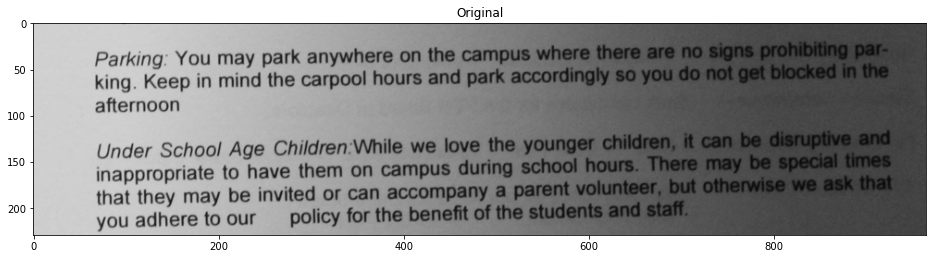

In [13]:
img = Image.open("sample01.png")
print(f"Format: \t{img.format}\nSize: \t\t{img.size}\nChannels: \t{img.mode}")
imshow(img, 'Original')

img = img.convert('L')
img = np.array(img)

In [14]:
# Original image results
get_metric_score(SAMPLE_1, SAMPLE_1_GROUND_TRUTH);

================== Results ==================

   '''
   Parking: You may park anywhere on the ce
   king. Keep in mind the carpool hours and park
   afternoon
   
   Under School Age Children:While we love
   inappropriate to have them on campus @ )
   that they may be invited or can accompany :
   you adhere to our _ policy for the benefit of
   '''
   
-> Jaccard Similarity:    	0.5263157894736842
-> Cosine Similarity:     	0.8512055557875504
-> Levenshtein Similarity:	0.6785260482846251

-> Average Score: 0.68535


C:\Users\wilso\AppData\Roaming\Python\Python36\site-packages\numpy\core\fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)


================== Results ==================

   '''
   Parking You may park anywhere on the ci
   king. Keep in mind the carpool hours and park
   afternoon
   
   Under School Age Children While we love
   inappropriate to have them on campus o 7
   that they may be invited or can accompany 4
   you adhere toour policy forthe benefit of
   '''
   
-> Jaccard Similarity:    	0.45
-> Cosine Similarity:     	0.8065705367762647
-> Levenshtein Similarity:	0.6713554987212276

-> Average Score: 0.64264


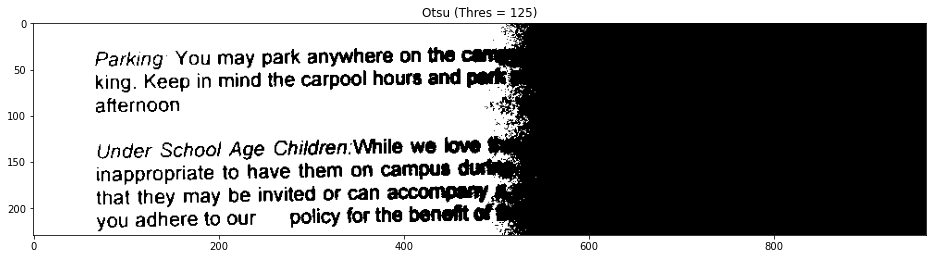

In [15]:
# img_cs = contrast_stretching(img)

otsu_img, otsu_thres = otsu_thresholding(img);
imshow(otsu_img, f'Otsu (Thres = {otsu_thres})')

get_metric_score(otsu_img, SAMPLE_1_GROUND_TRUTH);